# Lesson 2: Data Cleaning and preparation

This notebook contains my notes the second lesson. The lesson covered data preparation for a classification problem with three bears. The notebook show how to download images using the tool *googleimagedownlaod*. The lesson also covers *stochastic gradient descent* and a study on the effect of the learning rate.


## Data preparation

In order to spice things up. I will change the dataset to download images of **tigers** and create a network to differentiate between them. The class that I will download are :

* Panter
* Tiger
* Jagouar

To download the images we will use the `googleimagedownlaod` tool. The command to load a class is taken by specifing a *description* for the images and a folder for saving the images.

```bash
googleimagesdownload -k "Description" -s medium -l num_images -o dataSetName -i train/className
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

In [ ]:
# class names
classes  = ['panter', 'tiger', 'jagouar']

#descriptions
descriptions = ['panter animal', 'tiger animal', 'jagouar animal']

#images per class
image_per_class = 10

#dataset folder
dataset_folder = "../data/tigers"
#loop to download the three classes
for animal, description in zip(classes, descriptions):
    print("   Downloading class {} ".format(animal))
    !googleimagesdownload -k "{description}" -s medium -l {image_per_class} -o {dataset_folder} -i "test/"{animal}


Item no.: 1 --> Item name = panter animal
Evaluating...
^C

Item no.: 1 --> Item name = tiger animal
Evaluating...
Starting Download...
Completed Image ====> 1.149189-004-A892985B.jpg
Completed Image ====> 2.Tiger-in-Ranthambhore_Aditya-SinghGetty-22af655.jpg


In [2]:
#check the download files
!ls ../data/tigers/train/

jagouar  panter  tiger


## Training a simple model

In [3]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [4]:
path = Path("../data/tigers")
path.ls()

[PosixPath('../data/tigers/models'),
 PosixPath('../data/tigers/test'),
 PosixPath('../data/tigers/train')]

In [5]:
batch_size= 100

data = ImageDataBunch.from_folder(path,valid_pct=0.2,size=150,no_check=False);

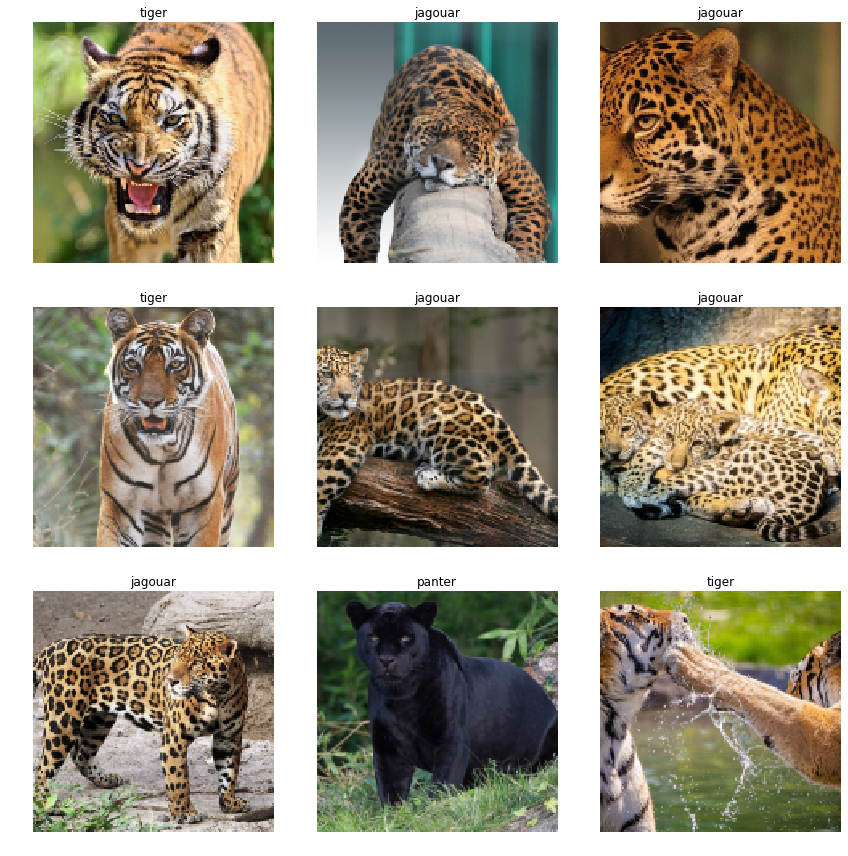

In [6]:
data.show_batch(3)

## Training A convolutional network

In [7]:
from fastai.metrics import accuracy
learner = cnn_learner(data,models.resnet34, metrics = [accuracy])

In [8]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.421773,0.906256,0.583333,00:03
1,1.398474,0.469168,0.916667,00:02
2,1.029555,0.281466,0.958333,00:02
3,0.790040,0.235206,0.958333,00:02


In [10]:
learner.save('stage_1')
Int = ClassificationInterpretation.from_learner(learner)

We already have a *95%* accuracy. Let see if we could get better results by investigating the data

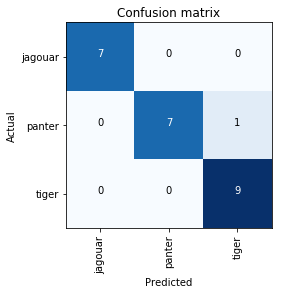

In [11]:
Int.plot_confusion_matrix()

In [12]:
from fastai.widgets import *

In [13]:
#getting the indices and path for the top losses images
ds,idx = DatasetFormatter.from_toplosses(learner)

In [14]:
#creating the  image cleaner object
ImageCleaner(ds,idx,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Putting the model in production

In [15]:
learner.export()


This will create a *explort.pkl* containing the all the information about the model. Those informations will be used when deploying in a website.

## Inference on cpu

Let's predict some images 
> It's recommended to do all the inference in the cpu, unless with have massive dataset

In [17]:
defaults.device = torch.device('cpu')


Now let's open an image with predifined function *open_image*

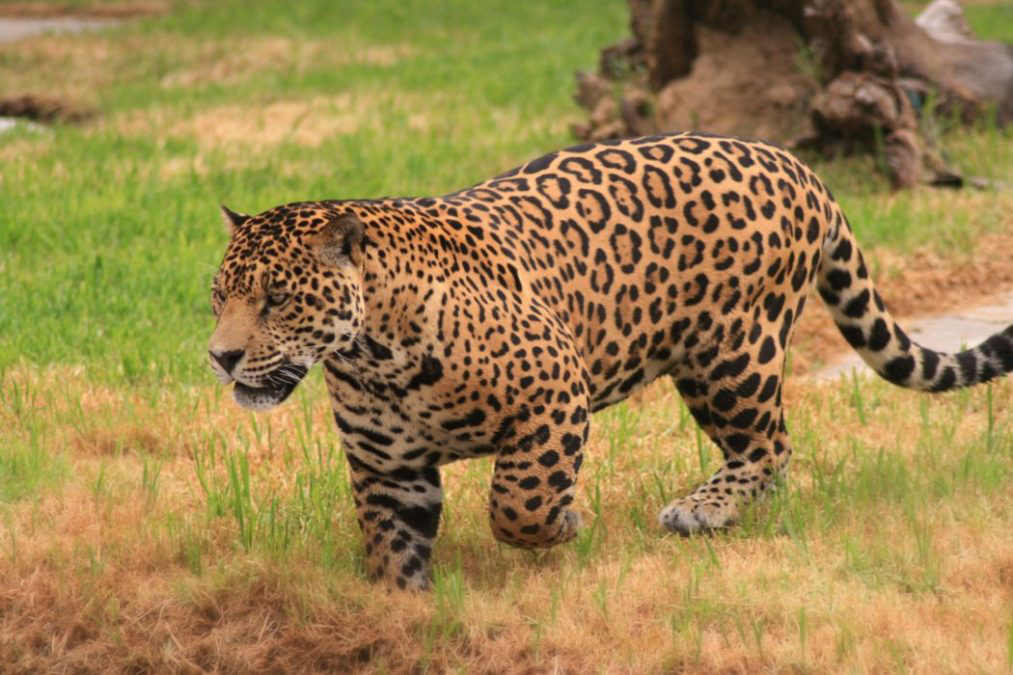

In [22]:
Img = open_image(path/'test'/'jagouar'/'1.jaguar-1310184-1.jpg')
Img

Let's now load our model and predict the class for this image

In [23]:
learner = load_learner(path)

In [30]:
predict_class, pred_idx, probs = learner.predict(Img)
print("   predicted class is {}".format(predict_class))
print("Probabilities are {}".format(probs))

   predicted class is jagouar
Probabilities are tensor([0.9695, 0.0148, 0.0156])


## Things that could go wrong in a learning

### 1 Learning rate too high

In [37]:
Learner = cnn_learner(data,models.resnet34, metrics = [accuracy])

In [38]:
Learner.fit_one_cycle(4,max_lr=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.458342,0.706316,0.791667,00:02
1,0.737756,3015.392578,0.375000,00:02
2,3.795652,1003808.937500,0.333333,00:02
3,8.236197,1054005.250000,0.333333,00:02


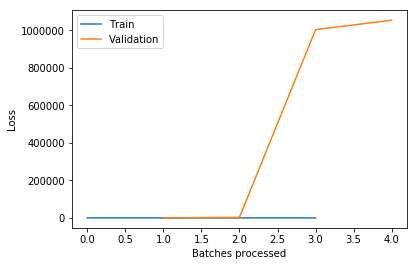

In [39]:
Learner.recorder.plot_losses()

We only get **29%** accuracy sincie our learning rate is too high

## 2 Learning rate too small

In [40]:
Learner = cnn_learner(data,models.resnet34, metrics = [accuracy])
Learner.fit_one_cycle(4,max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,1.650390,1.739184,0.458333,00:02
1,1.542039,1.570647,0.375000,00:02
2,1.473066,1.475158,0.416667,00:02
3,1.486767,1.406194,0.375000,00:02


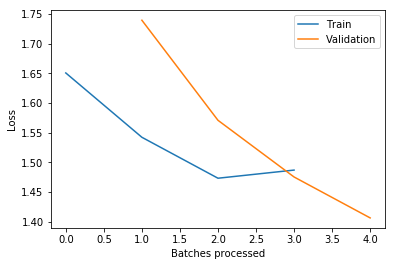

In [41]:
Learner.recorder.plot_losses()

Same get get **33%** which too slow compared to what we have before. We could also see that the validation loss become **smaller** than the train loss  which a bad indicator.

## 3) Too few epochs

In [42]:
Learner = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [43]:
Learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.605430,1.293035,0.416667,00:02
